# Quick Introduction to Bayesian Methods
## Matthew Heffernan
## McGill Nuclear Theory Journal Club, 18 September 2020
### Lightly adapted from Dick Furnstahl's excellent Physics 8805 course materials from The Ohio State University

* This notebook presents some tests of your installation using examples of the use of Bayesian statistics along with some background information.
* Some details appear (notably, MCMC) that I simply cannot introduce in sufficient detail in a general introduction.
* At the end of this session, we will conduct a poll about what people may be more interested in. 
* Hopefully, after today, you will have some more context about Bayesian methods and how to interpret and apply them.

The next topics I could potentially cover are:
* Markov-Chain Monte Carlo (MCMC) and some examples (multiple potential sessions)
* More in-depth Bayesian inference and Bayesian parameter estimation
* Gaussian Process emulators
* A discussion on Bayesian priors and what "non-informative" or "minimally-informative" mean

### Import of modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Not really needed, but nicer plots
import seaborn as sns

sns.set()
sns.set_context("talk")

In [2]:
# Modules needed for Illustrative Example 1
from scipy import stats
import emcee
import corner

# Learning from data

## Inference

> the act of passing from one proposition, statement or judgment considered as true to another whose truth is believed to follow from that of the former 

*(Webster)* 
  
Do premises $A, B, \ldots \Rightarrow$ hypothesis $H$? 

### Deductive inference:

> Premises allow definite determination of truth/falsity of H (syllogisms, symbolic logic, Boolean algebra) 

$B(H|A,B,...) = 0$ or $1$

### Inductive inference

> Premises bear on truth/falsity of H, but don’t allow its definite determination (weak syllogisms, analogies) 

* $A, B, C, D$ share properties $x, y, z$; 
* $E$ has properties $x, y$ 
* $\Rightarrow$ $E$ probably has property $z$.

## Statistical Inference
* Quantify the strength of inductive inferences from facts, in the form of data ($D$), and other premises, e.g. models, to hypotheses about the phenomena producing the data.

* Quantify via probabilities, or averages calculated using probabilities. Frequentists ($\mathcal{F}$) and Bayesians ($\mathcal{B}$) use probabilities very differently for this.

* To the pioneers such as Bernoulli, Bayes and Laplace, a probability represented a *degree-of-belief* or plausability: how much they considered something as true based on the evidence at hand. This is the Bayesian approach.

* To the 19th century scholars, this seemed too vague and subjective. They redefined probability as the *long run relative frequency* with which an event occurred, given (infinitely) many repeated (experimental) trials.

## The Bayesian recipe
Assess hypotheses by calculating their probabilities $p(H_i | \ldots)$ conditional on known and/or presumed information using the rules of probability theory.

### Probability Theory Axioms:

#### Product (AND) rule

  $$p(A, B | I) = p(A|I) p(B|A, I) = p(B|I)p(A|B,I)$$
  
  Should read $p(A,B|I)$ is the probability for propositions $A$ AND $B$ being true given that $I$ is true.

#### Sum (OR) rule
    
  $$p(A + B | I) = p(A | I) + p(B | I) - p(A, B | I)$$
  
  $p(A+B|I)$ is the probability that proposition $A$ OR $B$ is true given that $I$ is true.

#### Normalization

  $$p(A|I) + p(\bar{A}|I) = 1$$
  
  $\bar{A}$ denotes the proposition that $A$ is false.


## Bayes' theorem
Bayes' theorem follows directly from the product rule

$$
p(A|B,I) = \frac{p(B|A,I) p(A|I)}{p(B|I)}.
$$

The importance of this property to data analysis becomes apparent if we replace $A$ and $B$ by hypothesis($H$) and data($D$):

$$
p(H|D,I) = \frac{p(D|H,I) p(H|I)}{p(D|I)}.
$$

The power of Bayes’ theorem lies in the fact that it relates the quantity of interest, the probability that the hypothesis is true given the data, to the term we have a better chance of being able to assign, the probability that we would have observed the measured data if the hypothesis was true.

The various terms in Bayes’ theorem have formal names. 
* The quantity on the far right, $p(H|I)$, is called the **prior** probability; it represents our state of knowledge (or ignorance) about the truth of the hypothesis before we have analysed the current data. 
* This is modified by the experimental measurements through $p(D|H,I)$, the **likelihood** function, 
* The denominator $p(D|I)$ is called the **evidence**. It does not depend on the hypothesis and can be regarded as a normalization constant.
* Together, these yield the **posterior** probability, $p(H|D, I )$, representing our state of knowledge about the truth of the hypothesis in the light of the data. 

In a sense, Bayes’ theorem encapsulates the process of learning. The presence of other information, represented by $I$ in the conditional probabilities listed above, is (unfortunately) often suppressed in the formulation of Bayes' theorem.

## Illustrative example #1: Gaussian noise and averages
Adapted from Sivia: *Data Analysis: A Bayesian Tutorial*

Here we'll take a look at a simple parameter-estimation problem. We will compare the frequentist and Bayesian approaches. This problem is an extended version of Example 2 in Ch 2.3 of the book by Sivia. This short book is very readable and is highly recommended.

Let us consider the problem of estimating the mean and the variance of a normal distribution that is associated with a collection of random variables. The normal distribution
$$
p(x|\mu,\sigma) = \frac{1}{\sqrt{2\pi}\sigma} \exp \left(-\frac{(x-\mu)^2}{2\sigma^2} \right),
$$
is often used as a theoretical model to describe the noise associated with experimental data.

Let us assume that we have a series of $M$ measurements $D \equiv \{ x_k \} = (x_1, \ldots, x_M)$, that are samples from a normal $N(\mu, \sigma^2)$ population, from which we would like to learn the approximate values of the parameters $\mu$ and $\sigma$. The standard frequentist approach to this problem is the maximum likelihood method. The Bayesian approach is to compute the posterior distribution for the model parameters $\mu$ and $\sigma$.

Here we'll use Python to generate some toy data to demonstrate the two approaches to the problem. 

In [3]:
# Generating some data
np.random.seed(1)  # for repeatability we specify the seed

mu_true = 10.0  # true peak position
sigma_true = 1.0  # true standard deviation
M = 100  # number of measurements
D = stats.norm.rvs(mu_true, sigma_true, size=M)  # M measurements (samples)

First, let's make two simple visualizations of the "measured" data: a scatter plot and a histogram

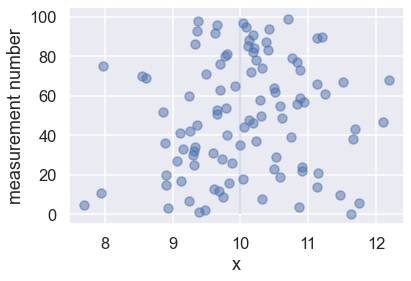

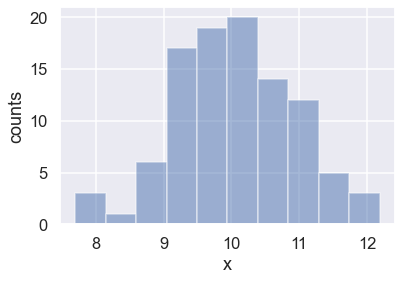

In [4]:
fig1, ax1 = plt.subplots()
ax1.scatter(D, np.arange(M), alpha=0.5)
ax1.vlines([mu_true], 0, M, alpha=0.2)
ax1.set_xlabel("x")
ax1.set_ylabel("measurement number")

fig2, ax2 = plt.subplots()
ax2.hist(D, alpha=0.5)
# ax1.vlines([mu_true], 0, M, alpha=0.2)
ax2.set_xlabel("x")
ax2.set_ylabel("counts");

### Frequentist approach to Gaussian parameter estimation

We'll start with the classical frequentist **maximum likelihood** approach. The probability of a single measurement $D_i$ having a value $x_i$ is given by 

$$ p(x_i~|~\mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp{\left[\frac{-(x_i - \mu)^2}{2 \sigma^2}\right]}, $$

where $\mu$, $\sigma$ are the *true* values for the model parameters.

We construct the **likelihood function** by computing the product of the probabilities for each data point:

$$\mathcal{L}(D~|~\mu, \sigma) = \prod_{i=1}^M p(x_i~|~\mu, \sigma)$$

Because the value of the likelihood can become very small, it is often more convenient to instead compute the log-likelihood. Furthermore, when we are looking for the maximum of the likelihood, we might just as well maximize the log-likelihood. Combining the previous two equations and computing the log, we have

$$\log\mathcal{L} = -\frac{1}{2} \sum_{i=1}^M \left[ \log(2\pi  \sigma^2) + \frac{(x_i - \mu)^2}{\sigma^2} \right]$$

What we'd like to do is find $\mu_0,\sigma_0$ such that the likelihood (or log likelihood) is maximized. For this simple problem, the maximization can be computed analytically (i.e. by setting $\left. \partial\log\mathcal{L}/\partial\mu \right|_{\mu_0,\sigma_0} = \left. \partial\log\mathcal{L}/\partial\sigma \right|_{\mu_0,\sigma_0} = 0$).  This results in the following *maximum-likelihood estimates* of the true parameters:

$$ 
\mu_0 = \frac{1}{M}\sum_{i=1}^M x_i \\
\sigma_0^2 = \frac{1}{M}\sum_{i=1}^M (x_i - \mu_0)^2
$$

In principle, we should also compute the second derivatives to make sure that this point represents a maximum rather than a minimum or a saddle point. However, in agreement with intuition, $\mu_0$ is simply the mean of the observed data. These results are fairly simple calculations; let's evaluate them for our toy dataset:

In [5]:
# Estimators: sample mean and (sqrt of) sample variance
# Sometimes the *unbiased* estimator for the sample variance is used with
#  (M-1) degrees of freedom [more on this later]
mu_est = D.sum() / M
sigma_est = np.sqrt(((D - mu_est) ** 2).sum() / M)
print(
    f"""
       (mu,sigma)_true = {mu_true:.2f}, {sigma_true:.2f}
      
       Sample estimators:
       (mu,sigma)_0  = {mu_est:.2f}, {sigma_est:.2f} (based on {M} measurements)
      """
)


       (mu,sigma)_true = 10.00, 1.00
      
       Sample estimators:
       (mu,sigma)_0  = 10.06, 0.89 (based on 100 measurements)
      


### Bayesian approach to Gaussian parameter estimation
The Bayesian approach begins and ends with probabilities.  It recognizes that what we fundamentally want to compute is our knowledge of the parameters in question, i.e. in this case,

$$ p(\mu,\sigma~|~D, I) $$

Note that this formulation of the problem is *fundamentally contrary* to the frequentist philosophy, which says that *probabilities have no meaning for model parameters* like $\mu,\sigma$. Nevertheless, within the Bayesian philosophy this is perfectly acceptable. 

To compute this result, Bayesians next apply [Bayes' Theorem](http://en.wikipedia.org/wiki/Bayes\'_theorem), here with the hypothesis being the Gaussian model expressed in terms of the model parameters

$$ p(\mu,\sigma~|~D, I) = \frac{p(D~|~\mu,\sigma, I)~p(\mu,\sigma~|~I)}{p(D~|~I)} $$

Though Bayes' theorem is where Bayesians get their name, it is not this law itself that is controversial, but the Bayesian *interpretation of probability* implied by the term $p(\mu,\sigma~|~D, I)$.

Let's take a look at each of the terms in this expression:

- $p(\mu,\sigma~|~D, I)$: The **posterior**, or the probability of the model parameters given the data: this is the result we want to compute.
- $p(D~|~\mu,\sigma, I)$: The **likelihood**, which is proportional to the $\mathcal{L}(D~|~\mu,\sigma)$ in the frequentist approach, above.
- $p(\mu,\sigma~|~I)$: The **model prior**, which encodes what we knew about the model prior to the application of the data $D$.
- $p(D~|~I)$: The **data probability**, which in practice amounts to simply a normalization term.

If we set the prior $p(\mu,\sigma~|~I) \propto 1$ (a *flat prior*), we find

$$p(\mu,\sigma~|~D,I) \propto \mathcal{L}(D|\mu,\sigma)$$

and the Bayesian probability is maximized at precisely the same value as the frequentist result! So despite the philosophical differences, we see that (for this simple problem at least) the Bayesian and frequentist point estimates are equivalent.

### But what about the prior?
You'll noticed that we glossed over something here: the prior, $p(\mu,\sigma)$. The choice of prior will be discussed in the course, but we can already note that it allows inclusion of other information into the computation. This feature becomes very useful in cases where multiple measurement strategies are being combined to constrain a single model. The necessity to specify a prior, however, is one of the more controversial pieces of Bayesian analysis.

A frequentist will point out that the prior is problematic when no true prior information is available. Though it might seem straightforward to use a **noninformative prior** like the flat prior mentioned above, there are some [surprisingly subtleties](http://normaldeviate.wordpress.com/2013/07/13/lost-causes-in-statistics-ii-noninformative-priors/comment-page-1/) involved. It turns out that in many situations, a truly noninformative prior does not exist! Frequentists point out that the subjective choice of a prior which necessarily biases your result has no place in statistical data analysis.

A Bayesian would counter that frequentism doesn't solve this problem, but simply skirts the question. Frequentism can often be viewed as simply a special case of the Bayesian approach for some (implicit) choice of the prior: a Bayesian would say that it's better to make this implicit choice explicit, even if the choice might include some subjectivity.

### Applying the Bayesian approach
Leaving these philosophical debates aside for the time being, let's address how Bayesian results are generally computed in practice. For a one parameter problem like the one considered here, it's as simple as computing the posterior probability $p(\mu,\sigma~|~D,I)$ as a function of $\mu,\sigma$: this is the distribution reflecting our knowledge of the parameter $\mu,\sigma$. But as the dimension of the model grows, this direct approach becomes increasingly intractable. For this reason, Bayesian calculations often depend on sampling methods such as [Markov Chain Monte Carlo (MCMC)](http://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo). 

We won't go into the details of the theory of MCMC here (again, we will be discussing this topic during the course). Instead we will show a practical example of applying an MCMC approach using Dan Foreman-Mackey's excellent [emcee](http://dan.iel.fm/emcee/current/)  package.  Keep in mind here that the goal is to *generate a set of points drawn from the posterior probability distribution*, and to use those points to determine the answer we seek.

To perform this MCMC, we start by defining Python functions for the prior $p(\mu,\sigma~|~I)$, the likelihood $p(D~|~\mu,\sigma, I)$, and the posterior $p(\mu,\sigma~|~D,I)$, noting that none of these need be properly normalized. Our model here is two-dimensional so we'll define the model in terms of an array of parameters $\theta$, which in this case is $\theta = [\mu,\sigma]$:

In [6]:
min_theta = np.array([0, 0])
max_theta = np.array([100, 10])
volume_theta = np.prod(max_theta - min_theta)


def log_prior(theta):
    """Log prior for parameter array theta"""
    assert len(theta) == 2, "Parameter vector must have length two."
    # flat prior
    if np.logical_and(min_theta <= theta, theta <= max_theta).all():
        return np.log(1 / volume_theta)
    else:
        return -np.inf


def log_likelihood(theta, X):
    """Log likelihood for data X given parameter array theta"""
    try:
        return -0.5 * np.sum(((X - theta[0]) / theta[1]) ** 2) - 0.5 * len(X) * np.log(
            2 * np.pi * theta[1] ** 2
        )
    except ValueError:
        return -np.inf


def log_posterior(theta, X):
    """Log posterior for data X given parameter array theta"""
    return log_prior(theta) + log_likelihood(theta, X)

Now we set up the problem, including generating some random starting guesses for the multiple chains of points.

In [7]:
ndim = 2  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 1000  # number of MCMC steps to take

# we'll start at random locations within the prior volume
starting_guesses = min_theta + max_theta * np.random.rand(nwalkers, ndim)

print(
    f"MCMC sampling using emcee (an affine-invariant ensamble sampler)",
    f"with {nwalkers} walkers".format(nwalkers),
)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[D])

# "burn-in" period; save final positions and then reset
pos, prob, state = sampler.run_mcmc(starting_guesses, nburn)
sampler.reset()

# sampling period
sampler.run_mcmc(pos, nsteps)

mean_acc_frac = np.mean(sampler.acceptance_fraction)
print(
    f"Mean acceptance fraction: {mean_acc_frac:.3f}",
    f"(in total {nwalkers*nsteps} steps)",
)

# Discard burn-in points and flatten the walkers;
#  the shape of samples is (nwalkers*nsteps, ndim)
samples = sampler.chain.reshape((-1, ndim))

MCMC sampling using emcee (an affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.711 (in total 50000 steps)


If this all worked correctly, the array *samples* should contain a series of draws from the posterior. Let's plot them using a so called corner plot (to be discussed in much more detail during the course).

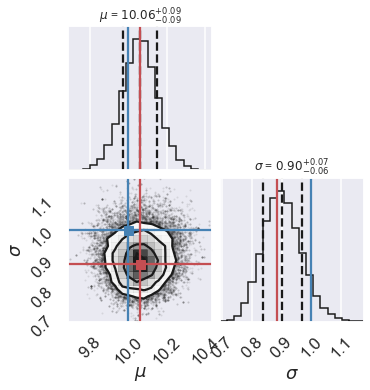

In [8]:
# Make a corner plot with the posterior distribution
fig = corner.corner(
    samples,
    labels=["$\mu$", "$\sigma$"],
    truths=[mu_true, sigma_true],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

# With some manual efforts, we can add the maximum-likelihood estimate
#  from the frequentist analysis
maxlike_results = (mu_est, sigma_est)

# First, extract the axes
axes = np.array(fig.axes).reshape((ndim, ndim))

# Then, loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(maxlike_results[i], color="r")

# And finally, loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(maxlike_results[xi], color="r")
        ax.axhline(maxlike_results[yi], color="r")
        ax.plot(maxlike_results[xi], maxlike_results[yi], "sr")

The lower left panel in the corner plot shows the joint probability distribution for the two model parameters. The two plots on the diagonal show marginalized distributions (with one parameter integrated out) for the two model parameters. The blue lines indicate the *true* values of the model parameters, while the title and the dashed lines indicate the most probable value as well as a 68% confidence interval. We will be discussing these representative measures of a posterior distribution during the course. 

The frequentist maximum-likelihood estimate from before is indicated by the red lines (that we added manually to the plot). As you can see, for this particular setup the maximum-likelihood estimate agrees with the most probable value from the MCMC sampling of the Bayesian posterior distribution.

The pure Bayesian result for a problem like this, however, would be to report the posterior distribution itself (i.e. its representative sample), and leave it at that. That is, in pure Bayesianism the answer to a question is not a single number with error bars; the answer is the posterior distribution over the model parameters! 

### Discussion
Now, you might come away with the impression that the Bayesian method is unnecessarily complicated, and in this case it certainly is. Using an Affine Invariant Markov Chain Monte Carlo Ensemble sampler to characterize a two-dimensional normal distribution is a bit like using the Death Star to destroy a beach ball, but we did this here because it demonstrates an approach that can scale to complicated posteriors in many, many dimensions, and can provide nice results in more complicated situations where an analytic likelihood approach is not possible.

# Check your understanding hands on: A standard medical example

Goal: Use the Bayesian rules to solve a familiar problem.

Physicist-friendly references:

* R. Trotta, [*Bayes in the sky: Bayesian inference and model selection in cosmology*](https://www.tandfonline.com/doi/abs/10.1080/00107510802066753), Contemp. Phys. **49**, 71 (2008)  [arXiv:0803.4089](https://arxiv.org/abs/0803.4089).
        
* D.S. Sivia and J. Skilling, [*Data Analysis: A Bayesian Tutorial, 2nd edition*]("https://www.amazon.com/Data-Analysis-Bayesian-Devinderjit-Sivia/dp/0198568320/ref=mt_paperback?_encoding=UTF8&me=&qid="), (Oxford University Press, 2006).
    
* P. Gregory,
     [*Bayesian Logical Data Analysis for the Physical Sciences: A Comparative Approach with Mathematica® Support*]("https://www.amazon.com/Bayesian-Logical-Analysis-Physical-Sciences/dp/0521150124/ref=sr_1_1?s=books&ie=UTF8&qid=1538587731&sr=1-1&keywords=gregory+bayesian"), (Cambridge University Press, 2010).

$% Some LaTeX definitions we'll use.
\newcommand{\pr}{\textrm{p}}
$

### Bayesian rules of probability as principles of logic 

Notation: $p(x \mid I)$ is the probability (or pdf) of $x$ being true
given information $I$

1. **Sum rule:** If set $\{x_i\}$ is exhaustive and exclusive, 
  $$ \sum_i p(x_i  \mid  I) = 1   \quad \longrightarrow \quad       \color{red}{\int\!dx\, p(x \mid I) = 1} 
  $$ 
    * cf. complete and orthonormal 
    * implies *marginalization* (cf. inserting complete set of states or integrating out variables - but be careful!)
  $$
   p(x \mid  I) = \sum_j p(x,y_j \mid I) 
    \quad \longrightarrow \quad
   \color{red}{p(x \mid I) = \int\!dy\, p(x,y \mid I)} 
  $$
   
  
2. **Product rule:** expanding a joint probability of $x$ and $y$         
     $$
         \color{red}{ p(x,y \mid I) = p(x \mid y,I)\,p(y \mid I)
              = p(y \mid x,I)\,p(x \mid I)}
     $$

    * If $x$ and $y$ are <em>mutually independent</em>:  $p(x \mid y,I)
      = p(x \mid I)$, then        
    $$
       p(x,y \mid I) \longrightarrow p(x \mid I)\,p(y \mid I)
    $$
    * Rearranging the second equality yields <em> Bayes' Rule (or Theorem)</em>
     $$
      \color{blue}{p(x  \mid y,I) = \frac{p(y \mid x,I)\, 
       p(x \mid I)}{p(y \mid I)}}
     $$

See <a href="https://www.amazon.com/Algebra-Probable-Inference-Richard-Cox/dp/080186982X/ref=sr_1_1?s=books&ie=UTF8&qid=1538835666&sr=1-1">Cox</a> for the proof.

## Medical tests and a disclaimer
Due to the times in which we live, it could be easy to generalize some of the intuition from this section to the current COVID-19 pandemic. However, I would caution before taking conclusions too far. Testing for COVID-19 has many factors and inferring information about disease prevalence, test accuracy, etc. without a proper appreciation for the underlying epidemiology and different testing strategies is dangerous. 

Advocating for conclusions based on incomplete or overly-simplistic analysis can have large real-world consequences. 

See also: [The Dunning-Kruger Effect](https://en.wikipedia.org/wiki/Dunning%E2%80%93Kruger_effect)

Suppose there is an unknown drug (call it UD) and there is a test for it.

a. The false positive rate is 2.3%. ("False positive" means the test says you use UD, but you don't.) <br>
b. The false negative rate is 1.4%. ("False negative" means you use UD, but the test says you don't.)

Assume that 1 in 10,000 people use the drug. Someone you know has received a positive test and you are worried they may lose their job. Your ultimate goal is to find the probability that your friend uses UD and perhaps cast sufficient doubt that they will not lose their job.  We'll do it using the Bayesian rules.

Assume that you know nothing about the typical user of UD and that the testing covers a representative sample of the population.

We'll use the notation:

* $H$ = "they use UD"
* $\overline H$ = "they do not use UD"  
* $D$ = "they test positive for UD"
* $\overline D$ = "they test negative for UD"  

1. *Before doing a calculation (or thinking too hard :), does your intuition tell you the probability they are a user is high or low?*
<br>
<br>

2. *In the $\pr(\cdot | \cdot)$ notation, what is your ultimate goal?*
<br>
<br>
<br>
<br>

3. *Express the false positive rate in $\pr(\cdot | \cdot)$ notation.* \[Ask yourself first: what is to the left of the bar?\]
<br>
<br>
<br>
<br>

4. *Express the false negative rate in $\pr(\cdot | \cdot)$ notation. By applying the sum rule, what do you also know? (If you get stuck answering the question, do the next part first.)* 
<br>
<br>
<br>
<br>

5. *Should $\pr(D|H) + \pr(D|\overline H) = 1$?
    Should $\pr(D|H) + \pr(\overline D |H) = 1$?
    (Hint: does the sum rule apply on the left or right of the $|$?)*
<br>
<br>
<br>
<br>

6. *Apply Bayes' theorem to your result for your ultimate goal (don't put in numbers yet).
   Why is this a useful thing to do here?*
<br>
<br>
<br>
<br>

7. Let's find the other results we need.  *What is $\pr(H)$?
  What is $\pr(\overline H)$?*
<br>
<br>
<br>
<br>

8. Finally, we need $\pr(D)$.  *Apply marginalization first, and then
  the product rule twice to get an expression for $\pr(D)$ in terms of quantities
  we know.*
<br>
<br>
<br>
<br>

9. *Now plug in numbers into Bayes' theorem and calculate the result.  What do you get?*
<br>
<br>
<br>
<br>